In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
from model_64 import Generator, Discriminator, Self_Attn
from IPython.display import clear_output
import datetime
import time
import os
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
from model_64 import Generator, Discriminator
from IPython.display import clear_output
import datetime
import time
import os

In [3]:
G = Generator()
G.load_state_dict(torch.load(r"C:\Users\akhsh\Desktop\WillDo\Idid\modelss\5600_G.pth"))

<All keys matched successfully>

In [4]:
D = Discriminator()
D.load_state_dict(torch.load(r"C:\Users\akhsh\Desktop\WillDo\Idid\modelss\5600_D.pth"))

<All keys matched successfully>

In [5]:
batch_size = 4

# Utility functions
def cuda(data):
    if torch.cuda.is_available():
        return data.cuda()
    else:
        return data

def denorm(x):
    out = (x + 1) / 2
    return out.clamp_(0, 1)

transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5]*3,[0.5]*3)])

train_data = train_data = ImageFolder(r"C:\Users\akhsh\Desktop\WillDo\Idid\samples_mnist\celeba", transform=transform)

dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


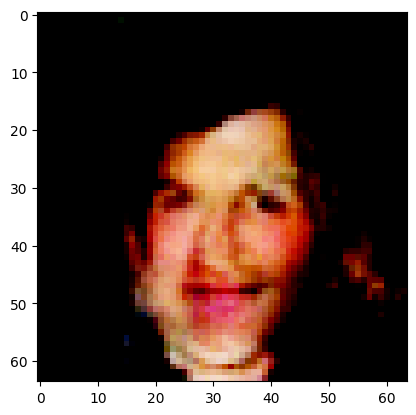

In [8]:
plt.imshow(G(torch.randn(1,100))[0].detach().numpy().transpose(1,2,0))

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

EPS = 0.003

def fanin_init(size, fanin=None):
    fanin = fanin or size[0]
    v = 1. / np.sqrt(fanin)
    return torch.Tensor(size).uniform_(-v, v)

class Critic(nn.Module):

    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        self.conv1 = nn.Conv2d(state_dim[0], 16, kernel_size=3, stride=1,padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1,padding=1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(6144, 512)
        
        self.fcs1 = nn.Linear(512,256)
        self.fcs1.weight.data = fanin_init(self.fcs1.weight.data.size())
        self.fcs2 = nn.Linear(256,128)
        self.fcs2.weight.data = fanin_init(self.fcs2.weight.data.size())

        self.fca1 = nn.Linear(action_dim,128)
        self.fca1.weight.data = fanin_init(self.fca1.weight.data.size())

        self.fc2 = nn.Linear(256,128)
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())

        self.fc3 = nn.Linear(128,1)
        self.fc3.weight.data.uniform_(-EPS,EPS)

    def forward(self, state, action):
        """
        returns Value function Q(s,a) obtained from critic network
        :param state: Input state (Torch Variable : [n,state_dim] )
        :param action: Input Action (Torch Variable : [n,action_dim] )
        :return: Value function : Q(S,a) (Torch Variable : [n,1] )
        """
        x = nn.functional.relu(self.conv1(state))
        x = nn.functional.relu(self.conv2(x))
        x = self.flatten(x)
        x = self.fc(x)
        s1 = F.relu(self.fcs1(x))
        s2 = F.relu(self.fcs2(s1))
        a1 = F.relu(self.fca1(action))
        x = torch.cat((s2,a1),dim=1)

        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


class Actor(nn.Module):

    def __init__(self, state_dim, action_dim, action_lim):
        super(Actor, self).__init__()
        
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_lim = action_lim

        self.conv1 = nn.Conv2d(state_dim[0], 16, kernel_size=3, stride=1,padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1,padding=1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(131072, 512)
        
        self.fc1 = nn.Linear(512,256)
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())

        self.fc2 = nn.Linear(256,128)
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())

        self.fc3 = nn.Linear(128,64)
        self.fc3.weight.data = fanin_init(self.fc3.weight.data.size())

        self.fc4 = nn.Linear(64,action_dim)
        self.fc4.weight.data.uniform_(-EPS,EPS)

    def forward(self, state):
        x = nn.functional.relu(self.conv1(state))
        x = nn.functional.relu(self.conv2(x))
        x = self.flatten(x)
        x = self.fc(x)
        x = nn.functional.softmax(x, dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        action = F.tanh(self.fc4(x))

        #action = action * self.action_lim

        return action





In [9]:
def train(steps = 100000, batch_size = 64, z_dim = 100, attn = True):

    G = cuda(Actor((3,64,64),100,100))
    D = cuda(Generator())
    D.load_state_dict(torch.load(r"C:\Users\akhsh\Desktop\WillDo\Idid\modelss\5600_G.pth"))
    Dis = cuda(Discriminator())
    Dis.load_state_dict(torch.load(r"C:\Users\akhsh\Desktop\WillDo\Idid\modelss\5600_D.pth"))

    cwd = os.getcwd()
    post='_attn' if attn else ''
    if not os.path.exists(cwd+'/samples_celeba_f'+post):
        os.makedirs(cwd+'/samples_celeba_f'+post)

    g_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, G.parameters()), 0.0001, [0.0,0.9])
    loss_fn = torch.nn.MSELoss()
    Iter = iter(dataloader)
    
    # Start timer
    start_time = time.time()
    
    for step in range(steps):

        G.train()
        try:
            real_images,_ = next(Iter)
        except:
            Iter = iter(dataloader)
            real_images,_ = next(Iter)
        

        noise = G(cuda(real_images))
        
        image = D(noise)
        g_loss_fake = (-1 * Dis(image).mean())
        g_loss = loss_fn(cuda(real_images),image) + g_loss_fake
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        

        if (step + 1) % 10 == 0:
            elapsed = time.time() - start_time
            expect = elapsed/(step + 1)*(steps-step-1)
            elapsed = str(datetime.timedelta(seconds=elapsed))
            expect = str(datetime.timedelta(seconds=expect))
            clear_output(wait=True)
            print("Elapsed [{}], Expect [{}], step [{}/{}]".
                  format(elapsed,expect,step + 1,steps))

        if (step + 1) % (100) == 0:
            z = np.random.randint(1,noise.shape[0])
            fake_images= D(noise)[z]
            save_image(denorm(fake_images), os.path.join(r"C:\Users\akhsh\Desktop\WillDo\Idid\trial\image", '{}_z__fake.png'.format(step + 1)))
            save_image(denorm(real_images[z]), os.path.join(r"C:\Users\akhsh\Desktop\WillDo\Idid\trial\image", '{}_z_real.png'.format(step + 1)))

        if (step+1) % (1000) == 0:
            torch.save(G.state_dict(),os.path.join(r"C:\Users\akhsh\Desktop\WillDo\Idid\trial\weight", '{}_z_C.pth'.format(step + 1)))

In [9]:
G = cuda(Actor((3,64,64),100,100))
D = cuda(Generator())
D.load_state_dict(torch.load(r"C:\Users\akhsh\Desktop\WillDo\Idid\modelss\5600_G.pth"))

<All keys matched successfully>

In [10]:
G.load_state_dict(torch.load(r"C:\Users\akhsh\Desktop\WillDo\Idid\trial\weight\50000_C.pth"))

<All keys matched successfully>

In [51]:
G(torch.randn(1,3,64,64).cuda())

tensor([[ 0.0005,  0.0171, -0.0223,  0.0548, -0.0118, -0.0725, -0.0218, -0.0256,
          0.0427,  0.0166, -0.0135,  0.0184, -0.0249, -0.0286,  0.0081, -0.0369,
          0.0301,  0.0210,  0.0527, -0.1163,  0.0062, -0.0325,  0.0462, -0.0961,
          0.0082, -0.0334, -0.0001,  0.0465, -0.0521,  0.0604, -0.0091,  0.0136,
         -0.0188,  0.0506, -0.0153, -0.0108,  0.0385,  0.0227,  0.0652,  0.0405,
          0.0139, -0.0011,  0.0059, -0.0087, -0.0130,  0.0013,  0.0007, -0.0308,
          0.0250, -0.0441, -0.0585,  0.0695,  0.0274, -0.0256, -0.0369,  0.0048,
         -0.0190,  0.0302, -0.0374, -0.0031, -0.0182,  0.0095, -0.0444, -0.0384,
         -0.0661, -0.0089,  0.0276, -0.0406, -0.0114,  0.0180,  0.0443,  0.0355,
         -0.0138,  0.0203, -0.0242,  0.0151,  0.0287, -0.0004,  0.0167, -0.0166,
          0.0313, -0.0018, -0.0328, -0.0208,  0.0224, -0.0271, -0.0207,  0.0072,
         -0.0201,  0.0173, -0.0007,  0.0123, -0.0073,  0.0410,  0.0155, -0.0344,
         -0.0273,  0.0147,  

In [52]:
fake_images= D(noise)
save_image(denorm(fake_images), os.path.join(r"C:\Users\akhsh\Desktop\WillDo\Idid\trial", '{}_fake.png'.format(10234 + 1)))